# Modalna analiza 3D vitkih paličnih struktur z MKE  #
Programska koda za izračun **lastnih frekvenc** in pripadajočih **modalnih oblik** po **metodi končnih elementov (MKE)**.

In [1]:
# Programski paketi #
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from ipywidgets import interact

In [2]:
# Globalne nastavitve #
#%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)        # Definiramo velikost izrisa grafov
plt.rcParams['figure.dpi'] = 100                # 200 je standard
np.set_printoptions(precision=2, suppress=True) # Definiramo način izpisa matrik

## Postavitev fizikalnega modela##
Izdelava **fizikalnega modela žerjava**. Preko definiranih **vozlišč** konstruiramo posamezne **končne elemente**. 

Definiramo tudi **robne pogoje** (fiksirana vozlišča).

In [3]:
# VOZLIŠČA - x in y koordinate
Voz = np.loadtxt(fname='tocke.txt', dtype='float', delimiter='\t', skiprows=1, usecols=(1,2,3))
# KONČNI ELEMENTI - Vozlišča oštevilčimo (od 1 naprej) in jih sestavimo v KE
KE = np.loadtxt(fname='koncni_elementi.txt', dtype='int', delimiter='\t', skiprows=1, usecols=(1,2))
# ROBNI POGOJI glede na mesta v globalni matriki
RP = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [4]:
# Podatki                 # konstrukcijsko jeklo
Ej = 210000 #MPa;         # modul elastičnosti
ro_j = 7.8E-6 #kg/mm^3    # gostota
A1 = 100 #mm^2            # površina prereza

In [5]:
def KE_izris(x,y,z,t1,t2):
    '''Funkcija za izrisovanje skice končnih elementov na podlagi dveh točk t1 in t2.
    
    Parametri:
    x  -  koordinata x
    y  -  koordinata y
    z  - koordinata z
    t1 -  prva točka v končnem elementu
    t2 -  druga točka v končnem elementu
    '''
    ax = fig.gca(projection='3d')
    x1, x2 = x[t1], x[t2]
    y1, y2 = y[t1], y[t2]
    z1, z2 = z[t1], z[t2]
    #ax.plot([x1,x2],[y1,y2],[z1,z2],'r.', linewidth=0.5)
    ax.plot([x1,x2],[y1,y2],[z1,z2],'k-', linewidth=0.6)
    
def KE_skica(x,y,z,t1,t2):
    '''Funkcija za izrisovanje končnih elementov na podlagi dveh točk t1 in t2.
    
    Parametri:
    x  -  koordinata x
    y  -  koordinata y
    z  - koordinata z
    t1 -  prva točka v končnem elementu
    t2 -  druga točka v končnem elementu
    '''
    ax = fig.gca(projection='3d')
    x1, x2 = x[t1], x[t2]
    y1, y2 = y[t1], y[t2]
    z1, z2 = z[t1], z[t2]
    ax.plot([x1,x2],[y1,y2],[z1,z2],'k--', alpha=0.2, linewidth=0.6)

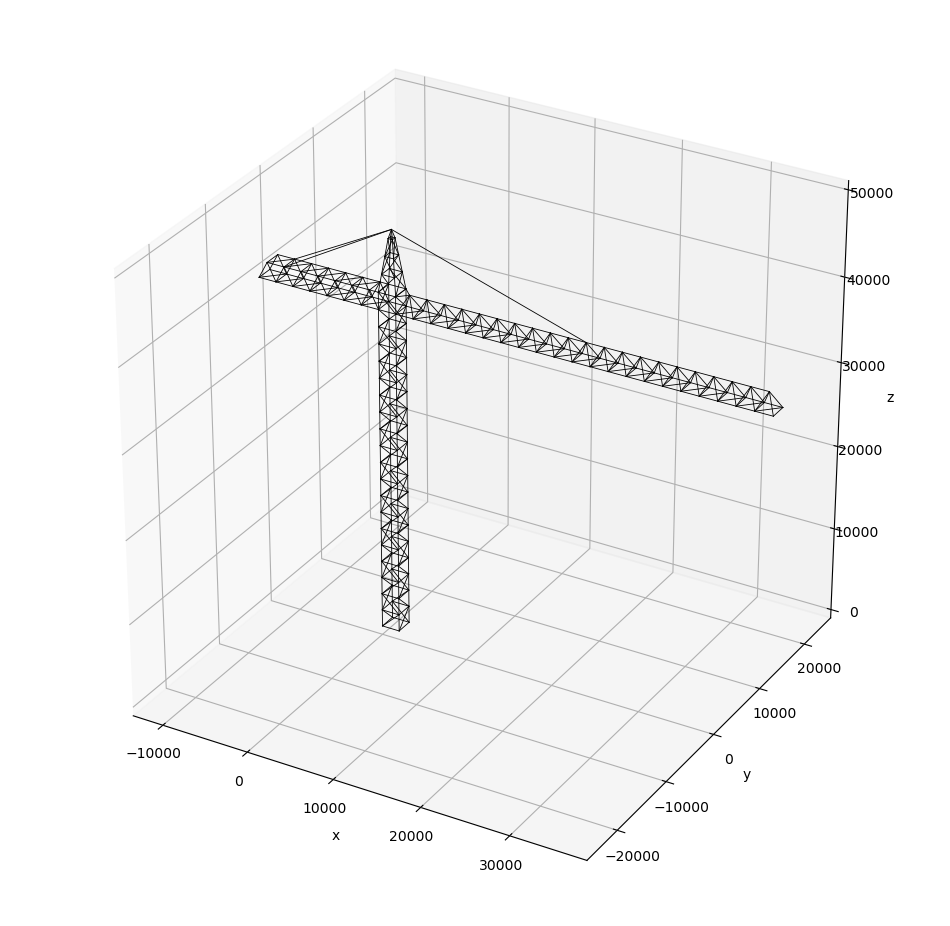

In [6]:
# Definiramo graf
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z') # oznaka osi

for i in KE:  # Sprehodimo se skozi vse končne elemente in vsakega izrišemo.
    KE_izris(Voz[:,0], Voz[:,1], Voz[:,2], i[0]-1, i[1]-1);

xmin, xmax = ax.get_xlim() # Določimo limite grafa
ymin, ymax = ax.get_ylim()
zmin, zmax = ax.get_zlim()

raz = 50000
ax.set_xlim(-1*raz/4, 3*raz/4); ax.set_ylim(-raz/2, raz/2); ax.set_zlim(0, raz);


plt.axis('on')
plt.savefig('model.png')












###

## Globalne matrike končnega elementa ##
Ker je potrebno uporabiti globalno definirana vozlišča, uporabimo izpeljavo masne in togostne matrike po transformaciji. 

Ker te matrike definiramo splošno, jih lahko kličemo z drugačnimi parametri in tako izdelamo različne končne elemente.

### Globalna masna matrike posameznega končnega elementa ### 

In [7]:
## Masna matrika ##
def M_ke(ro, A, L):
    '''Masna matrika v globalnem koordinatnem sistemu.
    
    Parametri:
    ro    - gostota materiala [kg/m^3]
    A     - površina prereza elementa [mm^2]
    L     - dolžina elementa [mm] 
    '''
    M = ro*A*L/6*np.array([
        [2, 0, 0, 1, 0, 0], 
        [0, 2, 0, 0, 1, 0], 
        [0, 0, 2, 0, 0, 1], 
        [1, 0, 0, 2, 0, 0],
        [0, 1, 0, 0, 2, 0],
        [0, 0, 1, 0, 0, 2]])
    return M

### Globalna togostna matrika posameznega končnega elementa ###

In [8]:
## Togostna matrika ##
def K_ke(alpha, beta, E, A, L):
    '''Togostna matrika v globalnem koordinatnem sistemu.
    
    Parametri:
    alpha - kot relativno na x os, kjer je z-os pri rotaciji vzporedna [rad]
    beta  - kot relativno na x os, kjer je y-os pri rotaciji vzporedna [rad]
    E     - modul elastičnosti [MPa]
    A     - površina prereza elementa [mm^2]
    L     - dolžina elementa [mm] 
    '''
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    cb = np.cos(beta)
    sb = np.sin(beta)
    K = E*A/L*np.array([
        [+ca**2*cb**2,  +ca*cb**2*sa, -ca*cb*sb, -ca**2*cb**2, -ca*cb**2*sa, +ca*cb*sb], 
        [+ca*cb**2*sa,  +cb**2*sa**2, -cb*sa*sb, -ca*cb**2*sa, -cb**2*sa**2, +cb*sa*sb], 
        [-ca*cb*sb,     -cb*sa*sb,    +sb**2,    +ca*cb*sb,    +cb*sa*sb,    -sb**2   ], 
        [-ca**2*cb**2,  -ca*cb**2*sa, +ca*cb*sb, +ca**2*cb**2, +ca*cb**2*sa, -ca*cb*sb],
        [-ca*cb**2*sa,  -cb**2*sa**2, +cb*sa*sb, +ca*cb**2*sa, +cb**2*sa**2, -cb*sa*sb],
        [+ca*cb*sb,     +cb*sa*sb  ,  -sb**2  ,  -ca*cb*sb   , -cb*sa*sb   , +sb**2   ]])
    return K













###

## Globalna masna in togostna matrika sistema ##
Iz posameznega končnega elementa sestavimo sistemski masni in togostni matriki.
### Skupna globalna masna matrika ###

In [9]:
M_glob_sist = np.zeros((Voz.size, Voz.size)) # definiramo prazno globalno masna matrika sistema glede na št. vozlišč
for ke in KE:                                                    # za vsak končni element v seznamu KE
    Voz1, Voz2 = Voz[ke[0]-1], Voz[ke[1]-1]                      # Python štetje prične z 0.
    ke_vek = Voz2 - Voz1                                         # vektor definiran na podlagi vozlišč k.e.
    ke_vek_L = np.linalg.norm(ke_vek)                            # velikost vektorjev oz. dolžina palic
    KE_glob = M_ke(ro_j, A1, ke_vek_L)                           # kličemo funkcijo masne matrike    
    ## Pripis matrike k.e. v sistemsko matriko ##    
    u11, u13 = 3*ke[0]-3, 3*ke[0]-1 # Definiramo neznane pomike k.e.
    u21, u23 = 3*ke[1]-3, 3*ke[1]-1    
    M_glob_sist[u11:u13+1,u11:u13+1] += KE_glob[0:3,0:3]
    M_glob_sist[u11:u13+1,u21:u23+1] += KE_glob[0:3,3:6]
    M_glob_sist[u21:u23+1,u21:u23+1] += KE_glob[3:6,3:6]
    M_glob_sist[u21:u23+1,u11:u13+1] += KE_glob[3:6,0:3]    
print(M_glob_sist)

[[2.3  0.   0.   ... 0.   0.   0.  ]
 [0.   2.3  0.   ... 0.   0.   0.  ]
 [0.   0.   2.3  ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.62 0.   0.  ]
 [0.   0.   0.   ... 0.   1.62 0.  ]
 [0.   0.   0.   ... 0.   0.   1.62]]


### Skupna globalna togostna matrika ###

In [10]:
K_glob_sist = np.zeros((Voz.size, Voz.size)) # definiramo prazno globalno togostno matrika sistema glede na št. vozlišč
for ke in KE:                                                    # za vsak končni element v seznamu KE
    Voz1, Voz2 = Voz[ke[0]-1], Voz[ke[1]-1]                      # Python štetje prične z 0.
    ke_vek = Voz2 - Voz1                                         # vektor definiran na podlagi vozlišč k.e
    ke_vek_L = np.linalg.norm(ke_vek)                            # velikost vektorjev oz. dolžina palic
    ke_kot_a = np.arctan2(ke_vek[1],ke_vek[0])                  # kot alfa; kot med x-osjo in vektorjem k.e.
    ke_kot_b = np.arcsin(ke_vek[2]/ke_vek_L)                    # kot beta; kot med x-osjo in vektorjem k.e.
    KE_glob = K_ke(ke_kot_a, ke_kot_b, Ej, A1, ke_vek_L)         # kličemo funkcijo togostne matrike    
    ## Pripis matrike KE v sistemsko matriko ##    
    u11, u13 = 3*ke[0]-3, 3*ke[0]-1 # Definiramo neznane pomike k.e.
    u21, u23 = 3*ke[1]-3, 3*ke[1]-1    
    K_glob_sist[u11:u13+1,u11:u13+1] += KE_glob[0:3,0:3]
    K_glob_sist[u11:u13+1,u21:u23+1] += KE_glob[0:3,3:6]
    K_glob_sist[u21:u23+1,u21:u23+1] += KE_glob[3:6,3:6]
    K_glob_sist[u21:u23+1,u11:u13+1] += KE_glob[3:6,0:3]
print(K_glob_sist)

[[14212.31    -0.   -3712.31 ...     0.       0.       0.  ]
 [   -0.   10500.       0.   ...     0.       0.       0.  ]
 [-3712.31     0.   14212.31 ...     0.       0.       0.  ]
 ...
 [    0.       0.       0.   ... 12378.3     -0.   -3756.59]
 [    0.       0.       0.   ...    -0.   10500.       0.  ]
 [    0.       0.       0.   ... -3756.59     0.    7513.19]]


### Robni pogoji ###
Na tem mestu iz obeh sistemskih matrik izbrišemo vrste in stolpce, ki sovpadajo z robnimi pogoji.

Razlog je v tem, da robni pogoj predstavlja pomik, ki je "zaklenjena" prostostna stopnja.

In [11]:
# Sistemska masna matrika #
M_glob_sist_RP = np.delete(M_glob_sist, RP, axis=0)
M_glob_sist_RP = np.delete(M_glob_sist_RP, RP, axis=1)

# Sistemska togostna matrika #
K_glob_sist_RP = np.delete(K_glob_sist, RP, axis=0)
K_glob_sist_RP = np.delete(K_glob_sist_RP, RP, axis=1)

print(M_glob_sist_RP)
print()
print(K_glob_sist_RP)

[[3.55 0.   0.   ... 0.   0.   0.  ]
 [0.   3.55 0.   ... 0.   0.   0.  ]
 [0.   0.   3.55 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 1.62 0.   0.  ]
 [0.   0.   0.   ... 0.   1.62 0.  ]
 [0.   0.   0.   ... 0.   0.   1.62]]

[[10500.      -0.      -0.   ...     0.       0.       0.  ]
 [   -0.   17924.62     0.   ...     0.       0.       0.  ]
 [   -0.       0.   28424.62 ...     0.       0.       0.  ]
 ...
 [    0.       0.       0.   ... 12378.3     -0.   -3756.59]
 [    0.       0.       0.   ...    -0.   10500.       0.  ]
 [    0.       0.       0.   ... -3756.59     0.    7513.19]]


## Iskanje lastnih frekvenc, vektorjev ter izris modalnih oblik ##

Osnova za iskanje lastnih vrednosti in lastnih vektorjev so definirane izpeljave. Toda v sistemu z velikim številom matrik (v resnici že pri $3x3$ matriki) postane postopek analitično težko rešljiv. 

V *Python* paketu *numpy.linalg* imamo funkcijo *eig*, ki numerično išče tako lastne vrednosti kot pripadajočo matriko lastnih vektorjev. 

Uporabnik lahko sam izriše in animira željeno modalno obliko.

In [12]:
lastnaVrednost, lastniVektor = np.linalg.eig(K_glob_sist_RP @ np.linalg.inv(M_glob_sist_RP))

idx = lastnaVrednost.argsort()        # Lastne vrednosti uredimo po velikosti
lastnaVrednost = lastnaVrednost[idx]
lastniVektor = lastniVektor[:,idx]
lastnaFrekvenca = (np.sqrt(lastnaVrednost)/(2*np.pi)) # Lastna frekvenca iz lastne vrednosti

In [13]:
print("število lastnih frekvenc in oblik je", np.size(lastnaFrekvenca))
print()
print("lastne frekvence: ")
print(lastnaFrekvenca)
print()
print("lastni vektorji:") 
print(lastniVektor)

število lastnih frekvenc in oblik je 552

lastne frekvence: 
[ 0.    0.01  0.01  0.02  0.03  0.08  0.12  0.12  0.13  0.18  0.18  0.19
  0.24  0.25  0.33  0.37  0.38  0.43  0.46  0.51  0.53  0.53  0.55  0.56
  0.67  0.72  0.74  0.77  0.82  0.84  0.87  0.89  0.96  1.    1.05  1.08
  1.12  1.18  1.22  1.24  1.27  1.35  1.4   1.41  1.47  1.51  1.54  1.58
  1.59  1.61  1.65  1.73  1.75  1.83  1.89  1.91  1.92  1.96  2.01  2.09
  2.15  2.19  2.2   2.22  2.3   2.32  2.34  2.37  2.45  2.5   2.54  2.61
  2.64  2.66  2.69  2.75  2.78  2.83  2.84  2.96  3.02  3.04  3.08  3.11
  3.12  3.17  3.24  3.29  3.3   3.35  3.38  3.42  3.52  3.53  3.55  3.57
  3.63  3.66  3.69  3.73  3.75  3.79  3.89  3.9   3.92  3.95  4.03  4.04
  4.09  4.1   4.11  4.14  4.24  4.27  4.33  4.35  4.42  4.46  4.47  4.48
  4.54  4.57  4.59  4.6   4.61  4.64  4.74  4.77  4.83  4.85  4.86  4.88
  4.92  5.07  5.11  5.12  5.16  5.21  5.25  5.28  5.34  5.36  5.4   5.43
  5.47  5.49  5.49  5.52  5.57  5.59  5.61  5.65  5.7   5.74  5

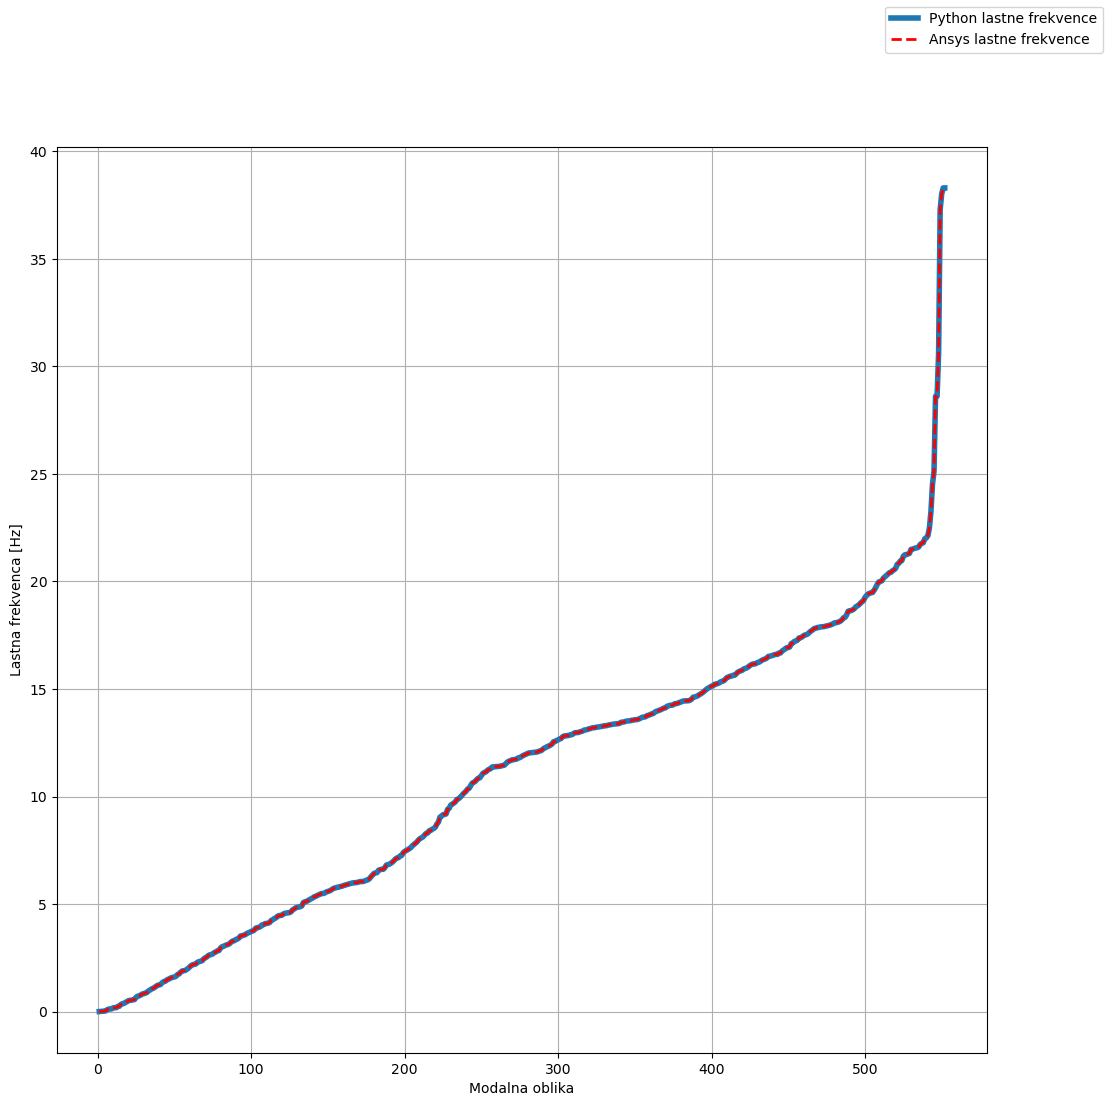

In [15]:
x=np.linspace(1,lastnaFrekvenca.size,lastnaFrekvenca.size)
y=lastnaFrekvenca
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=4.0, label = 'Python lastne frekvence')
ax.plot(x, y, ls='--', linewidth=2.0, label = 'Ansys lastne frekvence', color='r')

ax.set(xlabel='Modalna oblika', ylabel='Lastna frekvenca [Hz]')
ax.grid()
fig.legend()
fig.savefig("test.png")
plt.show()

In [23]:
%matplotlib notebook

<IPython.core.display.Javascript object>


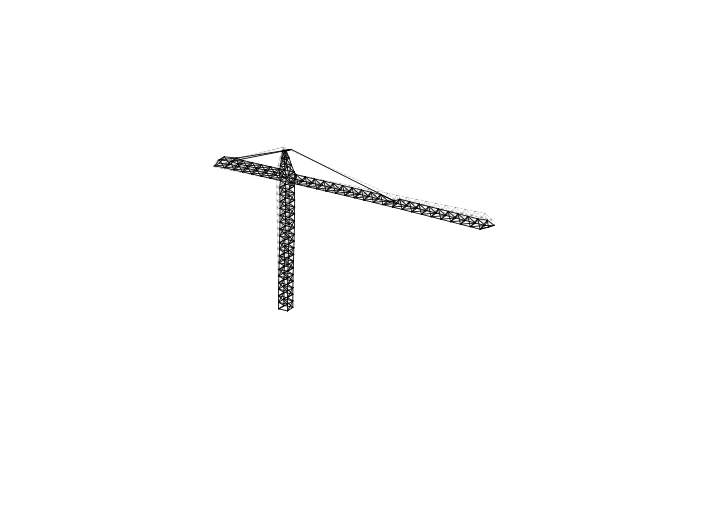

In [ ]:
f = 5                                             # parametri
A = 12000
t_max = 2/lastnaFrekvenca[f-1]
t_step = 3
premik_Voz0 = Voz.copy()                          # začetno stanje
fig = plt.figure()
n=1

for t in np.arange(0, t_max, t_step):
    X = A*np.sin(t*lastnaFrekvenca[f-1]*2*np.pi)  # "Amplituda" povečanja pomika v sinusni odvisnosti od t
    linVoz = np.reshape(Voz, -1).copy()
    j = 0
    for i in range(linVoz.size):                  # posamezni koordinati prištejemo vektor pomika (če ta ni robni pogoj)
        if i not in RP:
            linVoz[i] = linVoz[i] + X*lastniVektor[j,f-1]
            j+=1  
    premik_Voz = np.reshape(linVoz, (-1, 3))      # ponovno preoblikujemo v prvotno obliko 
    ax.clear()                                    #Brišemo prejšen graf pred prikazovanjem novega
    ax = fig.gca(projection='3d')
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z') # oznaka osi
    ax.set_xlim(-raz/4, 3*raz/4); ax.set_ylim(-raz/2, raz/2); ax.set_zlim(0, raz);
    for i in KE:                                  # izris za vsak k.e.
        KE_izris(premik_Voz[:,0], premik_Voz[:,1], premik_Voz[:,2], i[0]-1, i[1]-1);
        KE_skica(premik_Voz0[:,0], premik_Voz0[:,1], premik_Voz0[:,2], i[0]-1, i[1]-1);
    plt.axis('off')
    plt.pause(0.05)                               #Pavziramo in s tem manipuliramo animacijo
    fig.canvas.draw()

### MAC kriterij ###
Izračunamo MAC vrednost.

In [15]:
lastniVektorPython = lastniVektor
lastniVektorAnsys = lastniVektor#np.loadtxt(fname='AnsysVektorji.txt', dtype='float', delimiter='\t')
r1=lastniVektorPython
r2=lastniVektorAnsys

lastniVektorPython

array([[-0.  ,  0.  , -0.  , ...,  0.  , -0.  , -0.  ],
       [-0.  ,  0.  ,  0.  , ...,  0.  , -0.  , -0.  ],
       [ 0.  , -0.  , -0.  , ..., -0.  , -0.  ,  0.  ],
       ...,
       [ 0.  ,  0.03,  0.  , ...,  0.  , -0.  , -0.  ],
       [ 0.02,  0.  ,  0.05, ..., -0.  , -0.  ,  0.  ],
       [ 0.  , -0.02, -0.  , ..., -0.  ,  0.  ,  0.  ]])

In [ ]:
MAC_ij = np.array([])
for i in range(r1[0].size):
    for j in range(r1[0].size):
        MAC = np.abs(np.conj(r1[:, i]).T @ r2[:, j])**2/(np.conj(r1[:, i]) @ r1[:, i] * np.conj(r2[:, j]) @ r2[:, j])
        MAC_ij = np.append(MAC_ij, MAC)

In [ ]:
MAC_ij=MAC_ij.reshape((r1[0].size, r2[0].size), order='C')

In [ ]:
plt.rcParams["figure.figsize"] = (6.5,5)         # Definiramo velikost izrisa grafov
plt.rcParams['figure.dpi'] = 300                 # 200 je standard

SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
X = np.linspace(1, lastnaFrekvenca.size, r1[0].size, dtype=int)
Y = X
Z = MAC_ij

fig, ax0 = plt.subplots(1, 1)

c = ax0.pcolor(X, Y, Z, cmap='coolwarm', edgecolors="none", linewidth=0)
fig.colorbar(c, ax=ax0)
ax0.set_xlabel('Modalna oblika - Python')
ax0.set_ylabel('Modalna oblika - Ansys')
#ax0.set_title('Linearno skaliran MAC')

plt.show()

In [ ]:
xAmplitudes = np.linspace(1, 12, 12, dtype=int) #your data here
yAmplitudes = xAmplitudes #your other data here - must be same array length

x = np.array(xAmplitudes)   #turn x,y data into numpy arrays
y = np.array(yAmplitudes)   #useful for regular matplotlib arrays

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

#make histogram stuff - set bins - I choose 20x20 because I have a lot of data
hist, xedges, yedges = np.histogram2d(x, y, bins=(12,12))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = cm.get_cmap('coolwarm') # Get desired colormap - you can change this!
max_height = 0.5   # get range of colorbars so we can normalize
min_height = 0
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

c=ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average', edgecolor="black", linewidth=0.5)
plt.xlabel('Modalna oblika - Python')
plt.ylabel('Modalna oblika - Ansys')
#plt.colorbar(c)
plt.show()